In [39]:
import re
import random
import pandas as pd
import hashlib

In [40]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [41]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,250.549129,27.838792,82.515258,9
CCH Axcess,505.426409,17.428497,55.264280,29
DAX,603.754174,67.083797,255.433816,9
Azure DevOps Pipelines,624.399863,62.439986,153.054103,10
Azure AD Authentication,669.150111,83.643764,194.104585,8
Azure Private DNS,783.279524,87.031058,246.494857,9
Terraform,923.367638,76.947303,313.842626,12
TSQL,1176.568334,49.023681,161.589591,24
Azure VM + Developer,1652.601679,51.643802,404.884449,32
Azure Functions + PP365,1748.196290,109.262268,457.475298,16


# Histogram

sum of ages: ~43021.41


<Axes: >

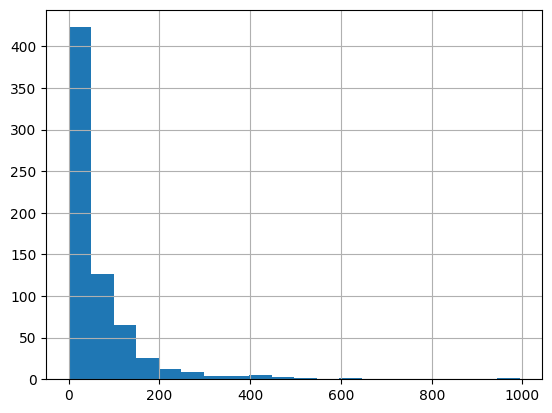

In [42]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~43021.41


<Axes: >

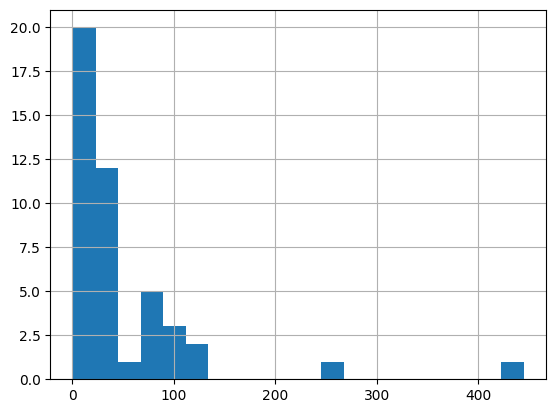

In [43]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [44]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [58]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 681
Total card age: 43021.41


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
24,PnP PowerShell,Retry Logic\nA programming practice where fail...,bcfbadc3960bd4bd3242daf149a9c17f,993.544186,78.176040,-993.544186,3908.802010,0.302085,50,0,0,-993.544186
99,Vocab,"How to Sell a Haunted House, Hendrix\nCrewelwo...",d77075a09e7acbd1920ff0f814f799c4,598.560582,67.461931,-598.560582,4115.177803,0.515901,61,0,0,-598.560582
321,C# Basics,What is the concept of properties in C#?\n\nC#...,44eb680a39c6697e0b62111790ae8512,500.413822,80.535551,-500.413822,2013.388766,0.969527,25,0,0,-500.413822
305,Azure Functions + PP365,Dynamic Content\nData dynamically pulled from ...,b118b5737fda1188f0c0c0b89d76e75e,457.475298,109.262268,-457.475298,1748.196290,0.212612,16,0,0,-457.475298
542,Azure Compute Gallery,Packer – An open-source tool that automates mu...,d17b1250166246417e0341a6e514c494,455.537371,72.005672,-455.537371,2448.192850,0.246268,34,0,0,-455.537371
532,Azure Functions + PP365,Azure Service Principal\nAn identity created f...,7274695dfcc476c136b846786d69aa32,453.663001,109.262268,-457.475298,1748.196290,0.212612,16,1,1,-453.663001
349,Azure Developer Associate,"In the .NET SDK for Azure Cosmos DB for NoSQL,...",b4367345e4f5cca6f2e90e685fdccbb2,444.813762,51.850250,-444.813762,2333.261229,0.578455,45,0,0,-444.813762
366,JavaScript Concepts,Parcel: A zero-configuration bundler that auto...,8853aee1ab1aab7096a1a8e936fedec1,441.952583,65.737204,-441.952583,4798.815859,0.321621,73,0,0,-441.952583
471,VMWare,ESXi Logging and Troubleshooting\n\nA set of l...,4a3cb826b5e67fd455122a49e48cb6d7,421.493791,63.981063,-421.493791,2431.280406,0.582648,38,0,0,-421.493791
184,Azure VM + Developer,Custom Script Extension\nA VM extension that a...,d3d8dede8b8008226b89c8604b75aac4,404.884449,51.643802,-404.884449,1652.601679,0.368460,32,0,0,-404.884449


# Headers with fewest notes first

In [46]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [47]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [48]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [49]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [50]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [51]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [52]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [ ]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


Cards found: 681
Total card age: 43021.41


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
24,PnP PowerShell,Retry Logic\nA programming practice where fail...,bcfbadc3960bd4bd3242daf149a9c17f,993.544186,78.17604,-993.544186,3908.80201,0.302085,50,0,0,-993.544186
492,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,211.836010,78.17604,-993.544186,3908.80201,0.302085,50,3,0,-211.836010
28,PnP PowerShell,Environment Variables\nVariables that are set ...,e888c7c4c00e3b122457c3d900fd4e77,154.504896,78.17604,-993.544186,3908.80201,0.302085,50,6,0,-154.504896
27,PnP PowerShell,PowerShell Profiles\nScripts that run automati...,52e04b62c431b8b8a3369ebe7b88db8c,119.048980,78.17604,-993.544186,3908.80201,0.302085,50,9,0,-119.048980
259,PnP PowerShell,Azure Key Vault Integration\nSecurely stores a...,accda5d72061d91a1b761cd2cb6550e4,84.407385,78.17604,-993.544186,3908.80201,0.302085,50,12,0,-84.407385
258,PnP PowerShell,Connect-PnPOnline (PnP.PowerShell)\nEstablishe...,874a3f0f70df8de5e68fa8b5f2ba77b1,76.324572,78.17604,-993.544186,3908.80201,0.302085,50,15,0,-76.324572
271,PnP PowerShell,SharePoint App Permissions\nDefines the access...,070e38162f80edb6a4f249647d0f042a,60.353769,78.17604,-993.544186,3908.80201,0.302085,50,18,0,-60.353769
33,PnP PowerShell,Get-AzureADServicePrincipal (AzureAD)\nRetriev...,db654e346072cf5b383457f54ff32239,32.356500,78.17604,-993.544186,3908.80201,0.302085,50,21,0,-32.356500
262,PnP PowerShell,PowerShell Scopes\nDefines the visibility and ...,a39c605667e4f38f731e19d41d5e8f47,25.769897,78.17604,-993.544186,3908.80201,0.302085,50,24,0,-25.769897
500,PnP PowerShell,New-PnPField (PnP.PowerShell)\nCreates a new f...,04508705a26781576ead2337537dc1ea,22.665016,78.17604,-993.544186,3908.80201,0.302085,50,27,0,-22.665016


## Card Count

In [54]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [55]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [56]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
24,PnP PowerShell,Retry Logic\nA programming practice where fail...,bcfbadc3960bd4bd3242daf149a9c17f,993.544186,78.176040,-993.544186,3908.802010,0.302085,50,0,0,-993.544186
99,Vocab,"How to Sell a Haunted House, Hendrix\nCrewelwo...",d77075a09e7acbd1920ff0f814f799c4,598.560582,67.461931,-598.560582,4115.177803,0.515901,61,0,0,-598.560582
321,C# Basics,What is the concept of properties in C#?\n\nC#...,44eb680a39c6697e0b62111790ae8512,500.413822,80.535551,-500.413822,2013.388766,0.969527,25,0,0,-500.413822
305,Azure Functions + PP365,Dynamic Content\nData dynamically pulled from ...,b118b5737fda1188f0c0c0b89d76e75e,457.475298,109.262268,-457.475298,1748.196290,0.212612,16,0,0,-457.475298
542,Azure Compute Gallery,Packer – An open-source tool that automates mu...,d17b1250166246417e0341a6e514c494,455.537371,72.005672,-455.537371,2448.192850,0.246268,34,0,0,-455.537371
532,Azure Functions + PP365,Azure Service Principal\nAn identity created f...,7274695dfcc476c136b846786d69aa32,453.663001,109.262268,-457.475298,1748.196290,0.212612,16,1,1,-453.663001
349,Azure Developer Associate,"In the .NET SDK for Azure Cosmos DB for NoSQL,...",b4367345e4f5cca6f2e90e685fdccbb2,444.813762,51.850250,-444.813762,2333.261229,0.578455,45,0,0,-444.813762
366,JavaScript Concepts,Parcel: A zero-configuration bundler that auto...,8853aee1ab1aab7096a1a8e936fedec1,441.952583,65.737204,-441.952583,4798.815859,0.321621,73,0,0,-441.952583
471,VMWare,ESXi Logging and Troubleshooting\n\nA set of l...,4a3cb826b5e67fd455122a49e48cb6d7,421.493791,63.981063,-421.493791,2431.280406,0.582648,38,0,0,-421.493791
184,Azure VM + Developer,Custom Script Extension\nA VM extension that a...,d3d8dede8b8008226b89c8604b75aac4,404.884449,51.643802,-404.884449,1652.601679,0.368460,32,0,0,-404.884449


In [57]:
existing_cards['age'].mean()

63.1738792851276